<a href="https://colab.research.google.com/github/rahiakela/transfer-learning-for-natural-language-processing/blob/main/2-getting-started-with-baselines/1_linear_and_tree_based_models_for_email_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear & Tree-based models for Email Sentiment Classification

Our goal is to establish a set of baselines for a pair of concrete NLP problems, which we will later be able to use to measure progressive improvements gained from leveraging increasingly sophisticated transfer learning
approaches. In the process of doing this, we aim to advance your general NLP instincts and refresh your understanding of typical procedures involved in setting up problem-solving pipelines for such problems. You will review techniques ranging from tokenization to data structure and model selection. We first train some traditional machine learning models from scratch to establish some preliminary baselines for these problems.

We will focus on a pair of important representative example NLP problems – spam
classification of email, and sentiment classification of movie reviews. This exercise will arm you with a number of important skills, including some tips for obtaining, visualizing and preprocessing data. 

Three major model classes will be covered, namely linear models such as logistic regression, decision-tree-based models such as random forests, and neural-network-based models such as ELMo. These classes are additionally represented by support vector machines (SVMs) with linear kernels, gradient-boosting machines (GBMs) and BERT respectively. 

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/content-classification-supervised-models.png?raw=1' width='800'/>



## Setup

In [39]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import email        # email package for processing email messages
import random
import re
import time


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC                              # Support Vector Classification model
from sklearn.ensemble import RandomForestClassifier      # random forest classifier library
from sklearn.model_selection import GridSearchCV         # for tune parameters systematically
from sklearn.ensemble import GradientBoostingClassifier  # GBM algorithm
from sklearn import metrics                              #Additional scklearn functions
from sklearn.model_selection import cross_val_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import files
files.upload() # upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahiakela","key":"484f91b2ebc194b0bff8ab8777c1ebff"}'}

In [3]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle
kaggle datasets download -d wcukierski/enron-email-dataset
unzip -qq enron-email-dataset.zip

kaggle datasets download -d rtatman/fraudulent-email-corpus
unzip -qq fraudulent-email-corpus.zip

rm -rf enron-email-dataset.zip fraudulent-email-corpus.zip

kaggle.json
 98% 350M/358M [00:04<00:00, 111MB/s] 
100% 358M/358M [00:04<00:00, 82.4MB/s]
 91% 5.00M/5.52M [00:00<00:00, 30.5MB/s]
100% 5.52M/5.52M [00:00<00:00, 27.0MB/s]


In [4]:
def extract_messages(df):
  messages = []
  for item in df["message"]:
    # Return a message object structure from a string
    e = email.message_from_string(item)
    # get message body
    message_body = e.get_payload()
    messages.append(message_body)
  print("Successfully retrieved message body from e-mails!")
  return messages

## Preprocessing Email Spam Classification Example Data

Here, we are interested in developing an algorithm that can detect whether any given email is spam or not, at scale. To do this, we will build a dataset from two separate sources – the popular Enron email corpus as a proxy for email that is not spam, and a collection of “419” fraudulent emails as a proxy for email that is spam.

We will view this as a supervised classification task, where we will first train a classifier on a collection of emails labeled as either spam or not spam. 

In particular, we will sample the Enron Corpus – the largest public email collection, related to the notorious Enron financial scandal – as a proxy for email that are not spam, and sample “419” fraudulent emails, representing the best known type of spam, as a proxy for email that is spam. Both of these types of emails are openly available on [Kaggle](https://www.kaggle.com/wcukierski/enron-email-dataset).

The Enron corpus contains about half a million emails written by employees of the Enron Corporation, as collected by the Federal Energy Commission for the purposes of investigating the collapse of the company. It has been used extensively in the literature to study machine learning methods for email applications and is often the first data source researchers working with emails look to for initial experimentation with algorithm prototypes. On Kaggle, it is
available as a single-column .csv file with one email per row. Note that this data is still cleaner than one can expect to typically find in many practical applications in the wild.

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/spam-email-preprocessing.png?raw=1' width='800'/>

The body of the email will first be separated from the headers of the email, some statistics about the dataset will be teased out to get a sense for the data, stopwords will be removed from the email, and it will then be classified as either spam or not spam.

### Loading and Visualizing the Fraudulent Email Corpus

Having loaded the Enron emails, let’s do the same for the “419” fraudulent email corpus, so that we can have some example data in our training set representing the “spam” class.

> Since this dataset comes as a .txt file, versus a .csv, the preprocessing steps are slightly different. First
of all, we have to specify the encoding when reading the file as latin1, otherwise the default encoding option of
utf-8 will fail. It is often the case in practice that one needs to experiment with a number of different encodings,
with the aforementioned two being the most popular ones, to get some datasets to read correctly. Additionally,
note that because this .txt file is one big column of emails (with headers) separated by line breaks and white
space, and is not separated nicely into rows with one email per row – as was the case for the Enron corpus – we
can’t use Pandas to neatly load it as was done before. We will read all the emails into a single string, and split
the string on a code word that appears close to the beginning of each email’s header, i.e, “From r”.

In [5]:
filepath = "./fradulent_emails.txt"
with open(filepath, "r", encoding="latin1") as file:
  data = file.read()

Print the first 20000 characters of read file string (this gives only a few emails), and notice the keyword From r close to the beginning of each email header

In [ ]:
print(data[:2000])

Split on the code word From r appearing close to the beginning of each email

In [7]:
fraud_emails = data.split("From r")
print("Successfully loaded {} spam emails!".format(len(fraud_emails)))

Successfully loaded 3978 spam emails!


Now that the fraudulent data is loaded as a list, we can convert it into a Pandas DataFrame.

In [8]:
fraud_bodies = extract_messages(pd.DataFrame(fraud_emails, columns=["message"], dtype=str))
fraud_bodies_df = pd.DataFrame(fraud_bodies[1:])

fraud_bodies_df.head()

Successfully retrieved message body from e-mails!


,0
0,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,"Dear sir, \n \nIt is with a heart full of hope..."


### Loading and Visualizing the Enron Corpus

The first thing we need to do is load the data with the popular Pandas library, and to take a peek at a slice of the data to make sure we have a good sense of what it looks like.

In [9]:
filepath = "./emails.csv"

# Read the enron data into a pandas.DataFrame called emails
emails = pd.read_csv(filepath)
print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(emails.head())

Successfully loaded 517401 rows and 2 columns!
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [10]:
# take a closer look at the first email
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


We see that the messages are contained within the message column of the resulting DataFrame, with the extra fields at the beginning of each message – including Message ID, To, From, etc.,– being referred to as the message’s header information or simply header.

Traditional spam classification methods derive features from the header information for classifying the message as spam or not. Here, we would like to perform the same task based on the content of the message only. One possible motivation for this approach is the fact that email training data may often be de-identified in practice due to privacy concerns and regulations, thereby making header info unavailable. Thus, we need to separate the headers from the messages in our dataset.

In [11]:
bodies = extract_messages(emails)

Successfully retrieved message body from e-mails!


In [12]:
# We then can display some processed emails
bodies_df = pd.DataFrame(bodies)
print(bodies_df.head())

                                                   0
0                          Here is our forecast\n\n 
1  Traveling to have a business meeting takes the...
2                     test successful.  way to go!!!
3  Randy,\n\n Can you send me a schedule of the s...
4                Let's shoot for Tuesday at 11:45.  


In [13]:
# extract random 10000 enron email bodies for building dataset
bodies_df = pd.DataFrame(random.sample(bodies, 10000))

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option("display.max_colwidth", 300)
# you could do print(bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames
bodies_df.head()

,0
0,"Britt-- I can't find them. Either Wayne Gresham or Gail Brownfeld has them.\n----- Forwarded by Richard B Sanders/HOU/ECT on 01/09/2001 10:25 AM -----\n\n\tTwanda Sweet\n\t01/08/2001 03:44 PM\n\t\t \n\t\t To: Richard B Sanders/HOU/ECT@ECT\n\t\t cc: \n\t\t Subject: Mailroom Issue\n\nRichard, do y..."
1,"\nAs a supporter of BIPAC you have access to a wide array of ""tools,"" charts,\npublications, the Candidate and Issues Databases, and many more.\n\nFind out where they are and how to use them. Attend one of our Use the Tools\nWorkshops on the morning of October 24th in BIPAC's Conference Room. \n..."
2,"Kate:\n\nThat is fine with me. Are we OK with this?\n\nC\n\n\n Kate Symes 04/13/2001 11:04 AM\n\nTo: Kimberly Hundl/Corp/Enron@Enron, Melissa Ann Murphy/HOU/ECT@ECT, Rhonda L \nDenton/HOU/ECT@ECT\ncc: Chris H Foster/HOU/ECT@ECT, Samuel Schott/HOU/ECT@ECT \nSubject: New CTPY Nam..."
3,I vote for waiting until Monday to discuss. This is one part of the larger \nPR / Government Affairs strategy in California. We need Karen Denne (PR) to \ncome to Portland for the meeting on Monday.\n\nJim\n\n\n\n\n\n\tTim Belden@ECT\n\t10/24/2000 05:54 PM\n\t\t \n\t\t To: Mark Palmer/Corp/Enr...
4,"\nPlease be aware that remote connectivity into the Enron network has changed, IPASS is no longer available. Remote Connectivity into Enron may be obtained by using the eConnect solution. Authorization to use eConnect may be requested via the eRequest system (you will find a link to eRequest o..."


The following (commented out) code is arguably the more "pythonic" way of achieving the extraction of bodies from messages. It is only 2 lines long and achieves the same result.

In [14]:
#messages = emails["message"].apply(email.message_from_string)
#bodies_df = messages.apply(lambda x: x.get_payload()).sample(10000)

### Email text preprocessing

Having loaded both datasets, we are now ready to sample emails from each one into a single DataFrame that will represent the overall dataset covering both classes of emails. Before doing this, we must decide how many samples to draw from each class. Ideally, the number of samples in each class will represent the natural distribution of emails in the wild, i.e, if we expect our classifier to encounter 60% spam emails and 40% nonspam emails when deployed, then a ratio such as 600 to 400 respectively might make sense.

**Note that a severe imbalance in the data, such as 99% for nonspam and 1% for spam may overfit to predict nonspam most of the time, an issue than needs to be considered when building datasets.** Since this is an idealized experiment, and we do not have any information on natural distributions of classes, we will
assume a 50/50 split. 

We also need to give some thought to how we are going to tokenize the emails, i.e., split emails into subunits of text - words, sentences, etc. To start off, we will tokenize into words, as this is the most common approach. 

We must also decide the maximum number of tokens per email, and the maximum length of each token, to ensure that the occasional “extremely long” email does not bog down the performance of our classifier. 

We do all these by specifying the following general hyperparameters, which will later be tuned experimentally to enhance performance as needed:

In [15]:
n_sample = 1000   # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 50    # the maximum number of tokens per document
maxtokenlen = 20  # the maximum length of each token

With these hyperparameters specified, we can now create a single DataFrame for the overarching training dataset. Let’s take the opportunity to also perform remaining preprocessing tasks, namely removing stop words, punctuations and tokenizing.

#### Tokenization

Let’s proceed by defining a function to tokenize emails by splitting them into words.

In [16]:
def tokenize(row):
  if row is None or row is "":
    tokens = ""
  else:
    tokens = str(row).split(" ")[:maxtokens]
  return tokens

#### Remove punctuation and unnecessary characters

Taking another look at the emails on the previous pair of pages, we see that they contain a lot of punctuation characters, and the spam emails tend to be capitalized. 

**In order to ensure that classification is done based on language content only, we have to remove punctuation marks and other non-word characters from the emails.** We do this by employing regular expressions with the Python regex library. We also normalize words by turning them into lower case.

In [17]:
def reg_expressions(row):
  tokens = []
  try:
    for token in row:
      token = token.lower()          # make all characters lower case
      token = re.sub(r"[\W\d]", "", token)
      token = token[:maxtokenlen]    # truncate all tokens to hyperparameter maxtokenlen
      tokens.append(token)
  except:
    token = ""
    tokens.append(token)
  return tokens

#### Stop-word removal

Finally, let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily used list that we will employ.

In [18]:
stop_words = stopwords.words("english")

def stop_word_removal(row):
  token = [token for token in row if token not in stop_words]
  token = filter(None, token)

  return token

### Assemble both Datasets

We are now going to put all these functions together to build the single dataset representing both classes. Most methods expect this dataset to be a Numpy array in order to process it, so we convert it to that form after combining the emails.

Now, putting all the preprocessing steps together we assemble our dataset...

In [19]:
# Convert everything to lower-case, truncate to maxtokens and truncate each token to maxtokenlen

# Apply predefined processing functions
enron_emails = bodies_df.iloc[:, 0].apply(tokenize)
enron_emails = enron_emails.apply(stop_word_removal)
enron_emails = enron_emails.apply(reg_expressions)
# sample the right number of emails from each class.
enron_emails = enron_emails.sample(n_sample)

# Apply predefined processing functions
spam_emails = fraud_bodies_df.iloc[:, 0].apply(tokenize)
spam_emails = spam_emails.apply(stop_word_removal)
spam_emails = spam_emails.apply(reg_expressions)
# sample the right number of emails from each class.
spam_emails = spam_emails.sample(n_sample)

# convert to Numpy array
raw_data = pd.concat([enron_emails, spam_emails], axis=0).values

Now, let’s take a peek at the result to make sure things are proceeding as expected:

In [20]:
print("Shape of combined data is:", raw_data.shape)
print("Data is:")
print(raw_data)

Shape of combined data is: (2000,)
Data is:
[list(['big', 'news', 'wolfcameracom', 'to', 'read', 'newsletter', 'online', 'go', 'httpwwwwolfcameracom', '', 'wolf', 'cameras', 'newsletter', 'holidays', '', 'vol', 'i', 'issue', 'imageimageimageimage', 'privacy', 'information', 'subscription', 'information', 'as', 'wolfcameracom', 'member', 'introduced', 'world', 'online', 'photographic', 'products', 'services', 'since'])
 list(['as', 'part', 'enron', 'industrial', 'markets', 'eim', 'move', 'pulp', 'paper', 'steel', 'markets', 'european', 'effort', 'well', 'underway', 'our', 'markets', 'global', 'in', 'nature', 'believe', 'need', 'strong', 'presence', 'europe', 'penetrate', 'that', 'market', 'effectively', 'accordingly', 'pleased', 'announce', 'bruce'])
 list(['note', 'information', 'background', 'ie', 'attributionalan', 'c', 'forwarded', 'alan', 'comnespdxect', '', '', 'pm', 'michael', 'etringer', '', 'amto', 'alan', 'comnespdxectectcc', 'subject', 'involuntary', 'bankruptcy', 'ca', 'forw

We see that the resulting array has divided the text into word units, as we intended to.

Let’s create the headers corresponding to these emails, consisting of n_sample=1000 of spam emails followed by n_sample=1000 of non-spam emails:

In [21]:
categories = ["spam", "notspam"]
header = ([1] * n_sample)
header.extend(([0] * n_sample)) 

We are now ready to convert this Numpy array into numerical features that can actually be fed to the algorithms for classification.

### Converting the Email Text Into Numbers

We start by employing what is often considered the simplest method for vectorizing words, i.e., converting them into numerical vectors – the bag-of-words model. This model simply counts the frequency of word tokens contained in each email and thereby represents it as a vector of such frequency counts.

Please observe that in doing this, we only retain tokens that appear more than once, as captured by the variable “used_tokens”. This enables us to keep the vector dimensions significantly lower than they would be otherwise. Please also
note that one can achieve this using various in-built vectorizers in the popular library scikitlearn.

We also note the scikit-learn vectorization methods include counting occurrences of sequences of any n words, or n-grams, as well as the tf-idf approach – important fundamental concepts you should brush on if rusty. For the problems looked at here, we did not notice an improvement when using these vectorization methods over the bag-of words approach.

The assemble_bag() function assembles a new dataframe containing all the unique words found in the text documents. It counts the word frequency and then returns the new dataframe.

In [22]:
def assemble_bag(data):
  used_tokens = []
  all_tokens = []

  for item in data:
    for token in item:
      if token in all_tokens:
        # If token has been seen before, append it to output list used_tokens
        if token not in used_tokens:
          used_tokens.append(token)
      else:
        all_tokens.append(token)

  df = pd.DataFrame(0, index=np.arange(len(data)), columns=used_tokens)

  # Create a Pandas DataFrame counting frequencies of vocabulary words – corresponding to columns, in each email – corresponding to rows
  for i, item in enumerate(data):
    for token in item:
      if token in used_tokens:
        df.iloc[i][token] += 1

  return df

We are now ready to convert these into numerical vectors!!

Having defined the assemble_bag function, let’s use it to actually carry out the vectorization and visualize it as follows:

In [23]:
# create bag-of-words model
enron_spam_bag = assemble_bag(raw_data) 

# this is the list of words in our bag-of-words model
predictors = [column for column in enron_spam_bag.columns]
print(enron_spam_bag)

      newsletter     information  ...  fasoi  departmentof  incidence
0              2  2            2  ...      0             0          0
1              0  0            0  ...      0             0          0
2              0  6            1  ...      0             0          0
3              0  0            0  ...      0             0          0
4              0  1            0  ...      0             0          0
...          ... ..          ...  ...    ...           ...        ...
1995           0  0            0  ...      0             0          0
1996           0  0            0  ...      0             0          0
1997           0  0            0  ...      1             1          0
1998           0  0            0  ...      0             0          0
1999           0  2            0  ...      0             0          1

[2000 rows x 4747 columns]


The column labels indicate words in the vocabulary of the bag-of-words model, and the numerical entries in each row correspond to the frequency counts of each such word for each of the 2000 emails in our dataset. Notice that it is an extremely sparse DataFrame, i.e., it consists mostly of values of 0.


Having fully vectorized the dataset, we must remember that it is not shuffled with respect to classes, i.e., it contains Nsamp = 1000 spam emails followed by an equal number of nonspam emails. Depending on how this dataset is split, in our case by picking the first 70% for training and the remainder for testing, this could lead to a training set composed of spam only, which would obviously lead to failure. In order to create a randomized ordering of class samples in the dataset, we will need to shuffle the data in unison with the header/list of labels.


In [24]:
# shuffle raw data first
def unison_shuffle_data(data, header):
  p = np.random.permutation(len(header))
  data = data[p, :]
  header = np.asarray(header)[p]

  return data, list(header)

As the very last step of preparing the email dataset for training by our baseline classifiers, we split it into independent training and testing or validation sets. This will allow us to evaluate the performance of the classifier on a set of data that was not used for training, an important thing
to ensure in machine learning practice. We elect to use 70% of the data for training, and 30% for testing/validation afterwards.

In [25]:
data, header = unison_shuffle_data(enron_spam_bag.values, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7 * data.shape[0])  # get 70% index value

# 70% of data for training
train_x = data[:idx, :]
train_y = header[:idx]

# remaining 30% for testing
test_x = data[idx:, :]
test_y = header[idx:]

print("train_x/train_y list details, to make sure they are of the right form:")
print(len(train_x))
print(train_x)
print(len(train_y))
print(train_y[:5])

train_x/train_y list details, to make sure they are of the right form:
1400
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1400
[0, 0, 0, 0, 1]


Since 70% of 2000 is 1400, looks good! (for n_sample=1000)

## Generalized Linear Models

Traditionally, the development of models in any area of applied mathematics has started with linear models. These models are mappings that preserve addition and multiplication in the input and output spaces. In other words, the net response from a pair of inputs will be the sum of the responses to each individual input. This property enables a significant reduction in associated
statistical and mathematical theory.

In this section, we will apply a pair of the most widely-used generalized linear machine learning algorithms to the pair of example problems that were introduced in the previous section– logistic regression and support vector machines (SVMs) with linear kernel. Other popular generalized linear machine learning models that will not be applied include the simple perceptron
neural architecture with a linear activation function, latent dirichlet allocation (LDA) and Naive Bayes.

### Logistic Regression

Logistic regression models the relationship between a categorical output variable and a set of input variables by estimating probabilities with the logistic function. Assuming the existence of a single input variables x, and a single output binary variable y with associated probability $P(y=1)=p$.

Now, let’s go ahead and build our classifier using the popular library scikit-learn.

In [26]:
def fit_model(train_x, train_y):
  model = LogisticRegression()  # Instantiate model

  try:
    model.fit(train_x, train_y)  # Fit model to prepared labeled data
  except:
    pass

  return model

Now let's fit this model to our data for IMDB classification example.

In [27]:
model = fit_model(train_x, train_y)

To evaluate performance, we must test on the “hold out” test/validation sets that were put together for each example.

In [28]:
predicted_labels = model.predict(test_x)

# print all labels for full trasparency
print("DEBUG::The logistic regression predicted labels are::")
print(predicted_labels)

DEBUG::The logistic regression predicted labels are::
[0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0
 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0
 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1
 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1
 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1
 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1
 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1

In [29]:
acc_score = accuracy_score(test_y, predicted_labels)

print("The logistic regression accuracy score is::")
print(acc_score)

The logistic regression accuracy score is::
0.9716666666666667


Before proceeding, it is important to address the use of accuracy as the metric for evaluating performance. Accuracy is defined as the ratio of correctly identified samples, i.e., the ratio of the number of true positives and negatives to the total number of samples. 

Other potential metrics that could be used here include precision – the ratio of the number of true positives to all predicted positives, and recall – the ratio of the number of true positives to all actual positives. These two measures could be useful if the costs of false positives and false negatives
(respectively) are particularly important. 

Crucially, the F1-score – the harmonic mean of precision and recall – strikes a balance between the two, and is particularly useful for imbalanced datasets. This is the most common situation in practice, making this metric very important.


### Support Vector Machine Classifier

SVMs has traditionally been the most popular kind of kernel method.
These methods attempt to find good decision boundaries by mapping data to a high dimensional space, using hyperplanes as decision boundaries and the kernel trick to reduce computing cost. When the kernel function is a linear function, SVMs are not only generalized linear models, but are indeed linear models.

Note that because this classifier takes a bit longer to train than the logistic regression one, we employ the inbuilt Python library time to determine the training time.

In [30]:
# Create a support vector classifier
clf = SVC(C=1, gamma="auto", kernel="linear", probability=False)

# Fit the classifier using the training data
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the SVC Classifier took %3d seconds" % (end_time - start_time))

# test and evaluate
predicted_labels = clf.predict(test_x)
print("DEBUG::The SVC Classifier predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("The SVC Classifier testing accuracy score is::")
print(acc_score)

Training the SVC Classifier took   4 seconds
DEBUG::The SVC Classifier predicted labels are::
[0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0
 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0
 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1
 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1
 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1
 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1
 0 0 1

Training the SVM classifier on the email data took 64 seconds, and yielded an accuracy score of 0.98. We see that SVM significantly underperforms logistic regression for the email spam classification problem, while achieving lower but nearly comparable performance for the IMDB problem.

## Decision-Tree-Based Models

A decision tree is a decision support aid that models decisions and their consequences as trees - a graph where any two nodes are connected by exactly one path. An alternative definition of a tree is a flowchart transforming input values into output categories.

In this section, we apply two of the most commonly used kinds of decision-tree-based methods – Random Forests and Gradient Boosting Machines – to the two illustrative running example problems. Other popular decision-tree-based methodologies that will not be explored include bagging, bootstrapping and boosting.

### Random Forests (RFs)

Random Forests (RFs) provide a practical machine learning method for applying decision trees. It involves generating a very large number of specialized trees and ensembling their outputs. RFs are extremely flexible and widely applicable, making them often the second algorithm practitioners try after logistic regression for baselining.

In [31]:
clf = RandomForestClassifier(n_jobs=1, random_state=0)

# Train the Classifier to take the training features and learn how they relate to the training y (spam, not spam?)
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the Random Forest Classifier took %3d seconds" % (end_time - start_time))

predicted_labels = clf.predict(test_x)
print("DEBUG::The RF predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("DEBUG::The RF testing accuracy score is::")
print(acc_score)

Training the Random Forest Classifier took   1 seconds
DEBUG::The RF predicted labels are::
[0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0
 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0
 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1
 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1
 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1
 0 0 1 0

Training the RF classifier on the email example data with this code took under a second in our experience, and achieved an accuracy score of 0.965.

In [32]:
# Now, tune parameters systematically
print("Available hyper-parameters for systematic tuning available with RF:")
print(clf.get_params())

Available hyper-parameters for systematic tuning available with RF:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [33]:
# select a subset of parameters to tune, and specify grid for each
param_grid = {
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 6, 10],
    "n_estimators": [10, 100, 1000]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# Fit the grid search to the data
grid_search.fit(train_x, train_y)

print("Best parameters found:")
print(grid_search.best_params_)

print("Estimated accuracy is:")
acc_score = accuracy_score(test_y, grid_search.best_estimator_.predict(test_x))
print(acc_score)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  4.7min finished


Best parameters found:
{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Estimated accuracy is:
0.97


This further confirms the initial hunch from previous section that the IMDB review problem is harder than the email classification problem that was set up.

### Gradient Boosting Machines (GBMs)

This variant of decision-tree-based machine learning algorithms iteratively learns new decisiontree- based models that address weak points of models from the previous iterations. At the time of this writing, they are widely considered to be the best class of methods for addressing nonperceptual
ML problems. This does come with some disadvantages unfortunately, including
larger model size, higher risk of overfitting and less interpretability than some other decisiontree models.

In [36]:
def modelfit(alg, train_x, train_y, predictors, test_x, performCV=True, printFeatureImportance=False, cv_folds=5):
  # Fit the algorithm on the data
  alg.fit(train_x, train_y)

  # Predict training set:
  predictions = alg.predict(train_x)
  predprob = alg.predict_proba(train_x)[:, 1]

  # Perform cross-validation:
  if performCV:
    cv_score = cross_val_score(alg, train_x, train_y, cv=cv_folds, scoring="roc_auc")

  # Print model report:
  print("\nModel Report")
  print("Accuracy : %.4g" % metrics.accuracy_score(train_y, predictions))
  print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, predprob))

  if performCV:
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

  # Print Feature Importance:
  if printFeatureImportance:
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp[:10].plot(kind="bar", title="Feature Importances")

  return alg.predict(test_x), alg.predict_proba(test_x)

In [37]:
gbm0 = GradientBoostingClassifier(random_state=10)

start_time = time.time()
test_predictions, test_probs = modelfit(gbm0, train_x, train_y, predictors, test_x)
end_time = time.time()
print("Training the Gradient Boosting Classifier took %3d seconds"%(end_time-start_time))

predicted_labels = test_predictions
print("DEBUG::The Gradient Boosting predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("DEBUG::The Gradient Boosting testing accuracy score is::")
print(acc_score)


Model Report
Accuracy : 0.9793
AUC Score (Train): 0.997339
CV Score : Mean - 0.9803378 | Std - 0.007387046 | Min - 0.9692029 | Max - 0.9912227
Training the Gradient Boosting Classifier took 113 seconds
DEBUG::The Gradient Boosting predicted labels are::
[1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0
 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0
 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1
 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1
 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0

Note that in addition to the usual training accuracy score, we report k-fold crossvalidation and the area under the Receiver Operating Characteristic curve (ROC AUC) to evaluate the model. We consider it necessary to do these here as GBMs are particularly prone to overfitting, and reporting these metrics helps us monitor that risk.

More specifically, k-fold cross validation (with default value of k=5 folds) randomly splits the training dataset into k partitions or folds, trains the model on k-1 of them while evaluating/validating performance on the remaining kth partition, repeating this process k times with each partition serving as a validation set. It then reports the performance using the statistics of these k evaluation iterations. This allows us to reduce the risk of the model
overfitting on some parts of the dataset while underperforming on others.

> **NOTE**: Put simply, overfitting refers to fitting too many parameters to too little data. This scenario hurts the model’s ability to generalize to new data, and often manifests as improving training metrics with no improvement in validation metrics. It can be alleviated by collecting more data, simplifying the model to reduce the number of training parameters.

We can see some evidence of overfitting, as the testing accuracy is lower than the k-fold training accuracy for the first example. Moreover, in the case of the IMDB example, the k-fold cross validation scores are noticeably lower than the training score on the overall dataset, underscoring the importance of using the k-fold cross-validation approach for tracking overfitting in this model type.

So what exactly is the ROC curve? The ROC curve is the plot of the false positive rate (FPR) versus the true positive rate (TPR). It is an important characteristic used to evaluate and tune classifiers. It shows the tradeoff in these important qualities of a classifier as the decision threshold, the probability value beyond which a predicted confidence begins to be classified as
a member of a given class, is varied between 0 and 1.

600


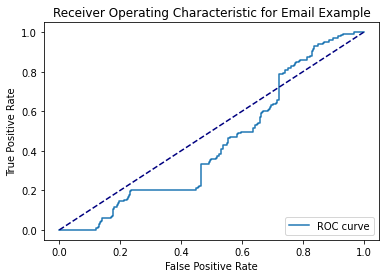

In [40]:
# Make an ROC curve

# first need to find probabilities corresponding to most likely class (max probability)
test_probs_max = []
for i in range(test_probs.shape[0]):
  test_probs_max.append(test_probs[i, test_y[i]])
print(len(test_probs_max))

# now, generate the curve data
fpr, tpr, thresholds = metrics.roc_curve(test_y, np.array(test_probs_max))

# plot curve data
fig,ax = plt.subplots()
plt.plot(fpr,tpr,label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Email Example')
plt.legend(loc="lower right")
plt.show()

The straight line with slope of 1 in the figure represents the FPR versus TPR tradeoff corresponding to random chance. The further to the left the ROC curve is from this line, the better performing the classifier. As a result, the area under the Receiver Operating Characteristic curve (ROC AUC) can be used as a measure of performance.

It is important to caution you, however, that while these importance scores seem to work well for this example, they should not always be blindly trusted. For instance, it has been widely recognized that these importance scores can be biased towards continuous variables, as well as high cardinality categorical variables.

### XGBoost Model classifier